In [1]:
import math 
import random
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from abc import abstractmethod
from tqdm import tqdm
from copy import deepcopy
%matplotlib inline
np.random.seed(20)

# Defining Stationary and Nonstationary Bandits

In [2]:
class Bandit: 
    """
    Each lever has an expected reward randomly drawn
    from a standard normal. When each lever is pulled, 
    the reward received is drawn from a standard normal
    centered at the lever's expected reward
    """
    def __init__(self, k):
        self.means = np.random.normal(size=k)
        
    def reinit(self): 
        self.means = np.random.normal(size=self.means.shape[0])
    
    def pull(self, action):
        return np.random.normal(loc=self.means[action])

In [3]:
class NonStationaryBandit(Bandit):
    """
    Before every pull, chooses a lever at random and resamples
    its expected reward with probability `resample_prob`. 
    """
    def __init__(self, k, resample_prob): 
        super().__init__(k)
        self.resample_prob = resample_prob
    
    def pull(self, action): 
        if random.random() < self.resample_prob:
            i = random.randrange(len(self.means))
            self.means[i] = np.random.normal()
        
        return super().pull(action)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10675.25it/s]


Text(0.5, 1.0, 'Multi-Armed Bandit Rewards')

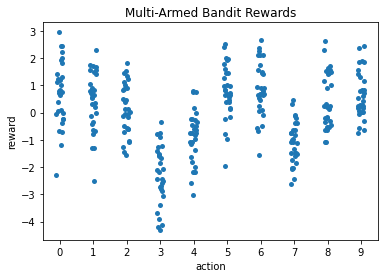

In [4]:
k = 10
bandit = Bandit(k)
cats = []
rewards = []

n = 30
for i in tqdm(range(k)):
    cats += [i for _ in range(n)]
    rewards += [bandit.pull(i) for _ in range(n)]
    
data = {'action': cats, 'reward': rewards}

sns.stripplot(data=data, x='action', y='reward').set_title("Multi-Armed Bandit Rewards")

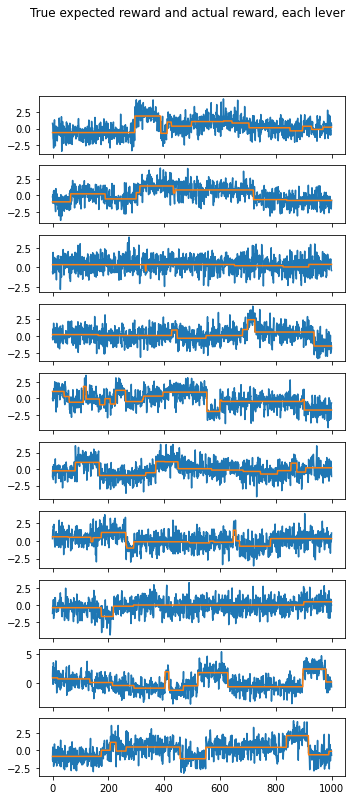

In [5]:
bandit = NonStationaryBandit(10, .05)
lever = 0

fig, axs = plt.subplots(10, 1, sharex=True)

for lever in range(10):
    rewards = []
    mean_rewards = []
    for i in range(1000): 
        bandit.pull(0)
        rewards.append(bandit.pull(lever))
        mean_rewards.append(bandit.means[lever])

    axs[lever].plot(rewards)
    axs[lever].plot(mean_rewards,)
    
fig.suptitle('True expected reward and actual reward, each lever')
fig.set_size_inches(5.5, 12.5)
plt.show()
    

# Bandit Algorithms

In [6]:
class BanditPolicy:
    @abstractmethod
    def reinit(self): 
        return 
    
    @abstractmethod
    def choose(self): 
        return 
    
    @abstractmethod
    def update(self, action, reward):
        return

In [7]:
class ActionValuePolicy(BanditPolicy):
    """
    Base action-value policy that supports eps-greedy exploration, 
    custom step size functions, and optimistic initialization
    """
    def __init__(self, k, eps=0, step_size_fn = lambda n: 1/n, 
                optimistic=True, optimistic_init_value=5.): 
        self.optimistic = optimistic
        if optimistic:
            self.optimistic_init_value = optimistic_init_value 
            self.values = np.full(k, optimistic_init_value)
        else: 
            self.values = np.zeros(k, dtype=float)
        
        self.n = 0
        self.step_size_fn = step_size_fn
        self.eps = eps
    
    def reinit(self): 
        if self.optimistic:
            self.values = np.full(self.values.shape[0], self.optimistic_init_value)
        else: 
            self.values = np.zeros(self.values.shape[0], dtype=float)
        
        self.n = 0
    
    def choose(self):         
        if random.random() < self.eps: 
            return random.randrange(self.values.shape[0])
        else: 
            greedy_idx = np.argmax(self.values)
            return greedy_idx
    
    def update(self, action, reward): 
        self.n += 1
        
        step_size = self.step_size_fn(self.n)
        step = step_size * (reward - self.values[action])
        
        self.values[action] += step

In [8]:
class UCBPolicy(ActionValuePolicy):
    def __init__(self, k, UCB_param, step_size_fn = lambda n: 1/n, 
                optimistic=True): 
        super().__init__(k, step_size_fn=step_size_fn, 
                         optimistic=optimistic)
        self.visits = np.zeros(k, dtype=int)
        self.c = UCB_param
        
    def reinit(self):
        super().reinit()
        self.visits = np.zeros(self.visits.shape[0], dtype=int)
        
        
    def choose(self): 
        if not self.visits.all():
            return np.argwhere(self.visits==0)[0]
        
        UCB_term = self.c * np.sqrt(math.log(self.n)/self.visits)
        weights = self.values + UCB_term 
        
        return np.argmax(weights)
    
    def update(self, action, reward): 
        super().update(action, reward)
        self.visits[action] += 1

In [9]:
class GradientBandit(BanditPolicy):
    def __init__(self, k, alpha=0.1, step_size_fn = lambda n: 1/n,):
        self.prefs = np.ones(k)
        self.n = 0
        self.step_size_fn = step_size_fn
        self.baseline = None
        self.alpha = alpha
    
    def choose(self): 
        return np.random.choice(len(self.prefs), p=softmax(self.prefs))
    
    def update(self, action, reward): 
        p = softmax(self.prefs)
        if self.baseline: 
            self.baseline = (self.n*self.baseline + reward)/(self.n+1)
        else: 
            self.baseline = reward
            
        self.n += 1
        
        alpha_diff = self.alpha*(reward-self.baseline)
        
        self.prefs[action] += alpha_diff * (1-p[action])
        
        mask = np.ones(len(self.prefs))
        mask[action] = 0 
        self.prefs -= mask*alpha_diff * p 

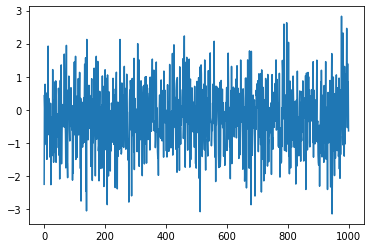

In [10]:
# Test run
bandit = Bandit(10)
policy = GradientBandit(10, 2)

rewards = []
for _ in range(1000):
    action = policy.choose()
    reward = bandit.pull(action)
    rewards.append(reward)
    policy.update(action, reward)
    
plt.plot(rewards)
plt.show()

# Evaluation

In [11]:
def avg_rewards(policies, pol_names, bandit, num_steps, avg_of):   
    assert len(policies) == len(pol_names)
    results = {}
    
    for policy, name in zip(policies, pol_names): 
        rollouts = [deepcopy(policy)for _ in range(avg_of)]
        [x.reinit() for x in rollouts]
        bandits = [deepcopy(bandit) for _ in range(avg_of)]
        [x.reinit() for x in bandits]
        
        avg_rewards = []
        for _ in tqdm(range(num_steps)):
            actions = [x.choose() for x in rollouts]
            rewards = [b.pull(a) for b, a in zip(bandits, actions)]
            [x.update(a, r) for x, a, r in zip(rollouts, actions, rewards)]
        
            avg_reward = sum(rewards)/len(rewards)
            avg_rewards.append(avg_reward)
        
        results[name] = avg_rewards
            
    return results

def plot_avg_rewards(results, title, xlabel, ylabel):
    for name in results: 
        plt.plot(results[name], label=name)
    leg = plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]
/home/zhangir/anaconda3/envs/proofnet/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


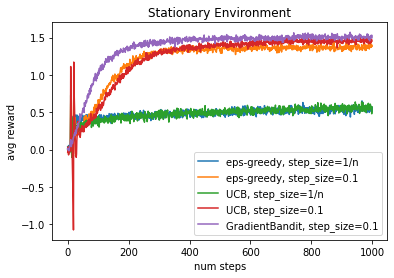

In [15]:
m = 2000
k = 10 
num_steps = 1000

policies = [ActionValuePolicy(k, eps=0.1), ActionValuePolicy(k, eps=0.1, step_size_fn=lambda n: 0.1), 
            UCBPolicy(k, 1), UCBPolicy(k, 1, step_size_fn=lambda n: 0.1), GradientBandit(k)]
names = ['eps-greedy, step_size=1/n', 'eps-greedy, step_size=0.1', 
         'UCB, step_size=1/n', 'UCB, step_size=0.1', 'GradientBandit, step_size=0.1']
bandit = Bandit(k)

results = avg_rewards(policies, names, bandit, num_steps=num_steps, avg_of=m)

plot_avg_rewards(results, "Stationary Environment", "num steps", "avg reward")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.55it/s]


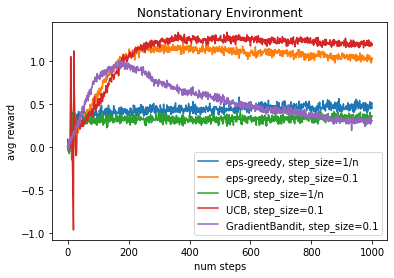

In [16]:
m = 2000
k = 10 
num_steps = 1000

policies = [ActionValuePolicy(k, eps=0.1), ActionValuePolicy(k, eps=0.1, step_size_fn=lambda n: 0.1), 
            UCBPolicy(k, 1), UCBPolicy(k, 1, step_size_fn=lambda n: 0.1), GradientBandit(k)]
names = ['eps-greedy, step_size=1/n', 'eps-greedy, step_size=0.1', 
         'UCB, step_size=1/n', 'UCB, step_size=0.1', 'GradientBandit, step_size=0.1']
bandit = NonStationaryBandit(k, .05)

results = avg_rewards(policies, names, bandit, num_steps=num_steps, avg_of=m)

plot_avg_rewards(results, "Nonstationary Environment", "num steps", "avg reward")